In [700]:
import librosa
import numpy as np
import os
import pandas as pd
import soundfile
import sys
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score,accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks 

%matplotlib inline

We define a function that takes a set of features per time frame and stack the mean so that the data becomes 1-Dimension.

In [56]:
def feature_to_1d(features):
    result = np.array([])
    mfcc = np.mean(features.T, axis=0)
    result = np.hstack((result, mfcc))
    return result

We import the binary files containing the original features (MFCCs, and Mel-Spectrogram) in 2D form, as well as the labels corresponding to each feature set.

In [686]:
#mel

f = open('IEMOCAP_Data/Data_30_sec/X_train_mel', 'rb')
X_train_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/X_test_mel', 'rb')
X_test_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/y_train_mel', 'rb')
y_train_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/y_test_mel', 'rb')
y_test_mel = joblib.load(f)
f.close()

#mfcc

f = open('IEMOCAP_Data/Data_30_sec/X_train_mfcc', 'rb')
X_train_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/X_test_mfcc', 'rb')
X_test_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/y_train_mfcc', 'rb')
y_train_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/y_test_mfcc', 'rb')
y_test_mfcc = joblib.load(f)
f.close()

## Find the indices of clipped audio (test)

In [682]:
X_test_mfcc.shape

(900, 40)

In [688]:
clipped_indices = []

for i in range(900):
    for j in range(40):
        for k in range(313):
            if(k == 312 and X_test_mel[i][j][k] != 0):
                clipped_indices.append(i)

len(clipped_indices)

1600

In [687]:
X_test_mel.shape

(900, 128, 872)

In [689]:
x_clipped =np.array(clipped_indices)
x_clipped =np.unique(x_clipped)

x_clipped

array([  5,  32,  37,  48,  69,  77,  80,  86, 107, 112, 116, 141, 145,
       154, 168, 172, 204, 210, 231, 236, 330, 351, 372, 417, 419, 464,
       482, 505, 587, 636, 693, 720, 733, 743, 756, 800, 811, 842, 852,
       897])

In [690]:
x_unclipped = []
for i in range(len(X_test_mel)):
    if i not in x_clipped:
        x_unclipped.append(i)
x_unclipped = np.array(x_unclipped)
#x_unclipped

len(x_unclipped)

860

## Examine clipped audio in train set

In [691]:
clipped_indices_train = []

for i in range(900):
    for j in range(40):
        for k in range(313):
            if(k == 312 and X_train_mel[i][j][k] != 0):
                clipped_indices_train.append(i)

x_clipped_t =np.array(clipped_indices_train)
x_clipped_t =np.unique(x_clipped_t)

len(x_clipped_t)

32

In [692]:
train_labels = []
for i in range(len(y_onehot_train_mfcc.argmax(axis=1))):
    if i in x_clipped_t:
        train_labels.append(y_onehot_train_mfcc.argmax(axis=1)[i])
test_labels = []
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if i in x_clipped:
        test_labels.append(y_onehot_test_mfcc.argmax(axis=1)[i])

len(test_labels)

40

In [693]:
from collections import Counter
train = Counter(train_labels)
test = Counter(test_labels)
print("Train: \n{} \n\nTest: \n{}".format(train, test))

Train: 
Counter({2: 12, 5: 9, 4: 6, 1: 3, 0: 2}) 

Test: 
Counter({2: 10, 1: 9, 0: 8, 4: 7, 5: 6})


In [694]:
print("Train count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(train_labels.count(0),train_labels.count(1),train_labels.count(2),train_labels.count(3),train_labels.count(4),train_labels.count(5)))

Train count:
Anger: 2
Happy: 3
Sad: 12
Fear: 0
Surprise: 6
Neutral: 9



In [695]:
print("Test count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(test_labels.count(0),test_labels.count(1),test_labels.count(2),test_labels.count(3),test_labels.count(4),test_labels.count(5)))

Test count:
Anger: 8
Happy: 9
Sad: 10
Fear: 0
Surprise: 7
Neutral: 6



In [696]:
dic_true_val = {}
dic_true_val['ang'] = test_labels.count(0)
dic_true_val['hap'] = test_labels.count(1)
dic_true_val['sad'] = test_labels.count(2)
dic_true_val['fea'] = test_labels.count(3)
dic_true_val['sur'] = test_labels.count(4)
dic_true_val['neu'] = test_labels.count(5)

## Unclipped audio

In [773]:
unclipped_indices_train = []

for i in range(900):
    for j in range(40):
        for k in range(313):
            if(k == 312 and X_train_mel[i][j][k] != 0):
                unclipped_indices_train.append(i)

x_unclipped_t =np.array(unclipped_indices_train)
x_unclipped_t =np.unique(x_unclipped_t)

len(x_unclipped_t)

32

In [774]:
train_labels = []
for i in range(len(y_onehot_train_mfcc.argmax(axis=1))):
    if i in x_unclipped_t:
        train_labels.append(y_onehot_train_mfcc.argmax(axis=1)[i])
test_labels = []
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if i in x_unclipped:
        test_labels.append(y_onehot_test_mfcc.argmax(axis=1)[i])

len(test_labels)

860

In [775]:
train = Counter(train_labels)
test = Counter(test_labels)
print("Train: \n{} \n\nTest: \n{}".format(train, test))

Train: 
Counter({2: 12, 5: 9, 4: 6, 1: 3, 0: 2}) 

Test: 
Counter({3: 158, 4: 158, 5: 144, 1: 144, 2: 134, 0: 122})


In [776]:
print("Test count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(test_labels.count(0),test_labels.count(1),test_labels.count(2),test_labels.count(3),test_labels.count(4),test_labels.count(5)))

Test count:
Anger: 122
Happy: 144
Sad: 134
Fear: 158
Surprise: 158
Neutral: 144



In [777]:
dic_true_val_unclipped = {}
dic_true_val_unclipped['ang'] = test_labels.count(0)
dic_true_val_unclipped['hap'] = test_labels.count(1)
dic_true_val_unclipped['sad'] = test_labels.count(2)
dic_true_val_unclipped['fea'] = test_labels.count(3)
dic_true_val_unclipped['sur'] = test_labels.count(4)
dic_true_val_unclipped['neu'] = test_labels.count(5)

### Converting to 1D Data

We convert the 2D features to 1D data.

In [59]:
X_train_mel_1d = []
X_test_mel_1d = []
X_train_mfcc_1d = []
X_test_mfcc_1d = []

In [60]:
for i in range(len(X_train_mel)):
    X_train_mel_1d.append(feature_to_1d(X_train_mel[i]))

In [61]:
for i in range(len(X_test_mel)):
    X_test_mel_1d.append(feature_to_1d(X_test_mel[i]))

In [62]:
for i in range(len(X_train_mfcc)):
    X_train_mfcc_1d.append(feature_to_1d(X_train_mfcc[i]))

In [63]:
for i in range(len(X_test_mfcc)):
    X_test_mfcc_1d.append(feature_to_1d(X_test_mfcc[i]))

In [64]:
X_train_mel = np.array(X_train_mel_1d)
X_test_mel = np.array(X_test_mel_1d)
X_train_mfcc = np.array(X_train_mfcc_1d)
X_test_mfcc = np.array(X_test_mfcc_1d)

In [65]:
X_train_mel.shape

(2100, 128)

In [66]:
X_train_mfcc.shape

(2100, 40)

### Transform the y data 

We transform the y data containing the labels into onehot-encoded form so that the models can classify the categorical accuracy and loss.

In [67]:
y_onehot_train_mel = y_train_mel
y_onehot_test_mel = y_test_mel

y_onehot_train_mfcc = y_train_mfcc
y_onehot_test_mfcc = y_test_mfcc

In [68]:
y_onehot_train_mel = pd.get_dummies(y_onehot_train_mel)
y_onehot_test_mel = pd.get_dummies(y_onehot_test_mel)

y_onehot_train_mfcc = pd.get_dummies(y_onehot_train_mfcc)
y_onehot_test_mfcc = pd.get_dummies(y_onehot_test_mfcc)

In [69]:
y_onehot_train_mel = np.asarray(y_onehot_train_mel).astype('int8')
y_onehot_test_mel  = np.asarray(y_onehot_test_mel).astype('int8')

y_onehot_train_mfcc = np.asarray(y_onehot_train_mfcc).astype('int8')
y_onehot_test_mfcc  = np.asarray(y_onehot_test_mfcc).astype('int8')

Import libraries needed for defining the models.

In [70]:
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Lambda, GlobalMaxPooling1D, Concatenate, BatchNormalization, LSTM, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.regularizers import l2

In [71]:
X_train_mfcc.shape

(2100, 40)

In [72]:
y_train_mfcc = np.asarray(y_train_mfcc)

Expand the dimensions for the training and testing data so that it can be used for the neural networks.

In [73]:
X_traincnn_mfcc = np.expand_dims(X_train_mfcc, axis = 2)
X_testcnn_mfcc = np.expand_dims(X_test_mfcc, axis = 2)
X_traincnn_mel = np.expand_dims(X_train_mel, axis = 2)
X_testcnn_mel = np.expand_dims(X_test_mel, axis = 2)

#### We define some functions for training and testing

In [74]:
import tensorflow as tf
import tensorflow.keras.backend as K

def f1_loss(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [697]:
def print_index(y_true, y_pred):
    #['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
    correct_instances_index = [] #indices of correct predictions
    for i in range(len(y_pred)):
        if(y_true[i] == y_pred[i]):
            correct_instances_index.append(i)
            
    return correct_instances_index
def print_labels(y_true, y_pred):
    #['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
    correct_instances_label = [] #labels of correct predictions
    for i in range(len(y_pred)):
        if(y_true[i] == y_pred[i]):
            correct_instances_label.append(y_pred[i])
            
    return correct_instances_label

In [698]:
def count_label(x):
    ang = 0
    hap = 0
    sad = 0
    fea = 0
    sur = 0
    neu = 0
    
    dic = {}
    #my_dict['name']='Nick'
    for i in range(len(x)):
        if(x[i]==0):
            ang += 1
        elif(x[i]==1):
            hap += 1
        elif(x[i]==2):
            sad += 1
        elif(x[i]==3):
            fea += 1
        elif(x[i]==4):
            sur += 1
        elif(x[i]==5):
            neu += 1
    dic['ang'] = ang
    dic['hap'] = hap
    dic['sad'] = sad
    dic['fea'] = fea
    dic['sur'] = sur
    dic['neu'] = neu
    
    return dic

In [75]:
checkpoint_path = 'IEMOCAP_Data/Weights/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)

### TDNN

We define the Time Delay Neural Netowrk Model. The model is based on a TDNN model used for flood prediction presented on ESoWC 2019 (MATHIW - Machine Learning Techniques for High Impact Weather) by Kugler & Lehner (https://github.com/MATEHIW-project).

In [597]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MinMaxNorm, NonNeg


def add_time(vector, time, name=None):
    """Converts numpy arrays to xarrays with a time coordinate.

    Parameters
    ----------
    vector : np.array
        1-dimensional array of predictions
    time : xr.DataArray
        the return value of `Xda.time`

    Returns
    -------
    xr.DataArray
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)


class DenseNN(object):
    def __init__(self, **kwargs):
        self.xscaler = StandardScaler()
        self.yscaler = StandardScaler()
        
        
        model = Sequential()
        self.cfg = kwargs
        
        hidden_nodes = self.cfg.get('hidden_nodes')
        input_shape = self.cfg.get('input_shape')
        self.epoch = self.cfg.get('epochs')
        self.batch_size = self.cfg.get('batch_size')
        
        

        model.add(layers.Input(shape=(input_shape, 1)))
        model.add(Dense(hidden_nodes[0], 
                                activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(self.cfg.get('dropout', None)))
        
        for n in hidden_nodes[1:]:
            model.add(Dense(n, activation='relu')) 
            model.add(BatchNormalization())
            model.add(Dropout(self.cfg.get('dropout', None)))
        model.add(Flatten())
        model.add(Dense(6, activation='softmax'))
        opt = tf.keras.optimizers.Adam(lr=0.0005) 
        
        #opt2 = tf.keras.optimizers.SGD(lr=0.0005)
        model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['categorical_accuracy', f1_loss])
        self.model = model

        self.callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1e-2, patience=100, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),]
    
    def score_func(self, X, y):
        """Calculate the RMS error
        
        Parameters
        ----------
        xr.DataArrays
        """
        ypred = self.predict(X)
        err_pred = ypred - y
        
        # NaNs do not contribute to error
        err_pred = err_pred.where(~np.isnan(err_pred), 0.)  
        return float(np.sqrt(xr.dot(err_pred, err_pred)))
        
    def predict(self, Xda, name=None):
        """Input and Output: xr.DataArray
        
        Parameters
        ----------
        Xda : xr.DataArray
            with coordinates (time,)
        """
        #X = self.xscaler.transform(Xda.values)
        #y = self.model.predict(X).squeeze()
        #y = self.yscaler.inverse_transform(y)
        
        #y = add_time(y, Xda.time, name=name)
        return self.model.predict(Xda)

    def evaluate(self, X, y):
        return self.model.evaluate(X, y)
    
    def fit(self, X_train, y_train, X_valid, y_valid, **kwargs):
        """
        Input: xr.DataArray
        Output: None
        """
        
        #print(X_train.shape)
        #X_train = self.xscaler.fit_transform(X_train)
        #y_train = self.yscaler.fit_transform(
                        #y_train.reshape(-1, 6))
        
        #X_valid = self.xscaler.transform(X_valid)
        #y_valid = self.yscaler.transform(y_valid.reshape(-1, 6))
        
        return self.model.fit(X_train, y_train,
                              validation_data=(X_valid, y_valid), 
                              epochs=self.epoch,
                              batch_size=self.batch_size, **kwargs)
    def predict_classes(X):
        return model.predict_classes(X)
    
    def summary(self):
        return self.model.summary()

#### MFCC

We use MFCC as input features.

In [462]:
X_train_mfcc_np = np.array(X_train_mfcc)
X_test_mfcc_np = np.array(X_test_mfcc)
y_train_mfcc_np = np.array(y_train_mfcc)
y_test_mfcc_np = np.array(y_test_mfcc)

In [463]:
X_test_mfcc_np.shape

(900, 40)

In [464]:
print(X_train_mfcc_np.shape)
print(X_test_mfcc_np.shape)
print(y_onehot_train_mfcc.shape)
print(y_onehot_test_mfcc.shape)

(2100, 40)
(900, 40)
(2100, 6)
(900, 6)


In [671]:
config = dict(hidden_nodes=(64, 32,16),  
                input_shape=40,
                dropout=0.25,
                epochs=35,
                batch_size=50)

m_2 = DenseNN(**config)

hist_2 = m_2.fit(X_traincnn_mfcc, y_onehot_train_mfcc, X_testcnn_mfcc, y_onehot_test_mfcc)

Epoch 1/35
42/42 [==============================] - 2s 20ms/step - loss: 2.5010 - categorical_accuracy: 0.1956 - f1_loss: 0.8305 - val_loss: 1.7871 - val_categorical_accuracy: 0.1900 - val_f1_loss: 0.8338
Epoch 2/35
42/42 [==============================] - 1s 13ms/step - loss: 2.1729 - categorical_accuracy: 0.2116 - f1_loss: 0.8132 - val_loss: 1.7538 - val_categorical_accuracy: 0.2333 - val_f1_loss: 0.8279
Epoch 3/35
42/42 [==============================] - 1s 13ms/step - loss: 1.8959 - categorical_accuracy: 0.2831 - f1_loss: 0.7747 - val_loss: 1.7397 - val_categorical_accuracy: 0.2367 - val_f1_loss: 0.8235
Epoch 4/35
42/42 [==============================] - 1s 13ms/step - loss: 1.7540 - categorical_accuracy: 0.3188 - f1_loss: 0.7515 - val_loss: 1.7112 - val_categorical_accuracy: 0.3422 - val_f1_loss: 0.8157
Epoch 5/35
42/42 [==============================] - 1s 13ms/step - loss: 1.6653 - categorical_accuracy: 0.3261 - f1_loss: 0.7392 - val_loss: 1.6997 - val_categorical_accuracy: 0.29

In [672]:
m_2.summary()

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_317 (Dense)            (None, 40, 64)            128       
_________________________________________________________________
batch_normalization_242 (Bat (None, 40, 64)            256       
_________________________________________________________________
dropout_297 (Dropout)        (None, 40, 64)            0         
_________________________________________________________________
dense_318 (Dense)            (None, 40, 32)            2080      
_________________________________________________________________
batch_normalization_243 (Bat (None, 40, 32)            128       
_________________________________________________________________
dropout_298 (Dropout)        (None, 40, 32)            0         
_________________________________________________________________
dense_319 (Dense)            (None, 40, 16)         

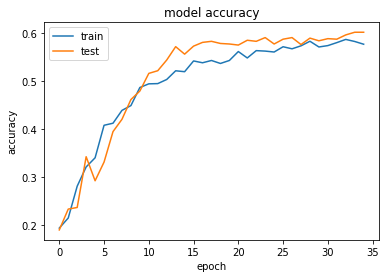

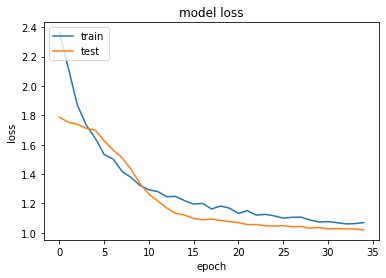

In [673]:
plt.plot(hist_2.history['categorical_accuracy'])
plt.plot(hist_2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [701]:
loss, acc, f1_score = m_2.evaluate(X_testcnn_mfcc, y_onehot_test_mfcc)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 4ms/step - loss: 1.0200 - categorical_accuracy: 0.6011 - f1_loss: 0.5521
Restored model, accuracy: 60.11%


Confusion matrix, without normalization
[[ 70  30   8   0   7  15]
 [ 31  67  16   2  19  18]
 [ 14  18  63   2  17  30]
 [  0   0   0 158   0   0]
 [  4  12  10   4 115  20]
 [ 10  24  30   2  16  68]]


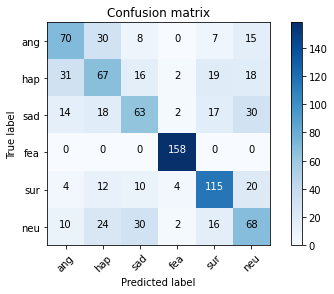

In [783]:
y_pred = m_2.predict(X_testcnn_mfcc)
matrix = metrics.confusion_matrix(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [784]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.54      0.54      0.54       130
         hap       0.44      0.44      0.44       153
         sad       0.50      0.44      0.46       144
         fea       0.94      1.00      0.97       158
         sur       0.66      0.70      0.68       165
         neu       0.45      0.45      0.45       150

    accuracy                           0.60       900
   macro avg       0.59      0.59      0.59       900
weighted avg       0.59      0.60      0.60       900



#### MEL

We use Mel-Spectrogram as input features.

In [607]:
X_train_mel_np = np.array(X_train_mel)
X_test_mel_np = np.array(X_test_mel)
y_train_mel_np = np.array(y_train_mel)
y_test_mel_np = np.array(y_test_mel)

In [623]:
config = dict(hidden_nodes=(64,32,16),  
                input_shape=128,
                dropout=0.25,
                epochs=60,
                batch_size=50)

m_mel_2 = DenseNN(**config)
hist_mel_2 = m_mel_2.fit(X_traincnn_mel, y_onehot_train_mel, X_testcnn_mel, y_onehot_test_mel)

Epoch 1/60
42/42 [==============================] - 4s 46ms/step - loss: 2.4606 - categorical_accuracy: 0.1914 - f1_loss: 0.8218 - val_loss: 1.7226 - val_categorical_accuracy: 0.2844 - val_f1_loss: 0.7680
Epoch 2/60
42/42 [==============================] - 2s 38ms/step - loss: 1.9965 - categorical_accuracy: 0.2805 - f1_loss: 0.7621 - val_loss: 1.6034 - val_categorical_accuracy: 0.3656 - val_f1_loss: 0.7409
Epoch 3/60
42/42 [==============================] - 1s 28ms/step - loss: 1.8285 - categorical_accuracy: 0.3390 - f1_loss: 0.7250 - val_loss: 1.5030 - val_categorical_accuracy: 0.4100 - val_f1_loss: 0.7200
Epoch 4/60
42/42 [==============================] - 1s 36ms/step - loss: 1.6313 - categorical_accuracy: 0.3874 - f1_loss: 0.6843 - val_loss: 1.4351 - val_categorical_accuracy: 0.4478 - val_f1_loss: 0.6997
Epoch 5/60
42/42 [==============================] - 2s 37ms/step - loss: 1.5712 - categorical_accuracy: 0.4248 - f1_loss: 0.6695 - val_loss: 1.3487 - val_categorical_accuracy: 0.48

In [624]:
m_mel_2.summary()

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_296 (Dense)            (None, 128, 64)           128       
_________________________________________________________________
batch_normalization_221 (Bat (None, 128, 64)           256       
_________________________________________________________________
dropout_275 (Dropout)        (None, 128, 64)           0         
_________________________________________________________________
dense_297 (Dense)            (None, 128, 32)           2080      
_________________________________________________________________
batch_normalization_222 (Bat (None, 128, 32)           128       
_________________________________________________________________
dropout_276 (Dropout)        (None, 128, 32)           0         
_________________________________________________________________
dense_298 (Dense)            (None, 128, 16)         

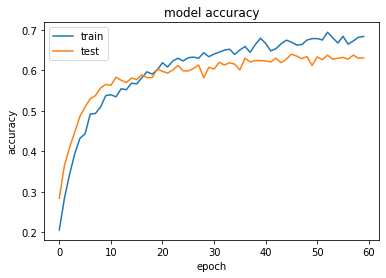

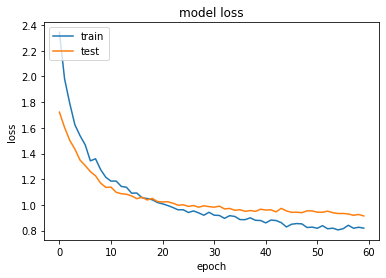

In [625]:
plt.plot(hist_mel_2.history['categorical_accuracy'])
plt.plot(hist_mel_2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_mel_2.history['loss'])
plt.plot(hist_mel_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [780]:
loss, acc, f1_score = m_mel_2.evaluate(X_testcnn_mel, y_onehot_test_mel)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 8ms/step - loss: 0.9144 - categorical_accuracy: 0.6311 - f1_loss: 0.4930
Restored model, accuracy: 63.11%


Confusion matrix, without normalization
[[ 89  20  10   0   5   6]
 [ 24  69  32   1  11  16]
 [ 17  22  61   2  14  28]
 [  0   0   0 158   0   0]
 [  0  19  12   0 130   4]
 [ 15  25  42   1   6  61]]


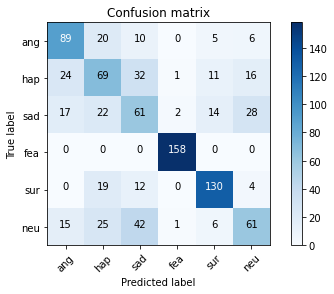

In [796]:
y_pred = m_mel_2.predict(X_testcnn_mel)
matrix = metrics.confusion_matrix(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [797]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.61      0.68      0.65       130
         hap       0.45      0.45      0.45       153
         sad       0.39      0.42      0.41       144
         fea       0.98      1.00      0.99       158
         sur       0.78      0.79      0.79       165
         neu       0.53      0.41      0.46       150

    accuracy                           0.63       900
   macro avg       0.62      0.63      0.62       900
weighted avg       0.63      0.63      0.63       900



## CNN + LSTM

We create a CNN model with LSTM based on a paper on Speech Emotion Recognition by Zhao et al., the reference to the github is: (https://github.com/vandana-rajan/1D-Speech-Emotion-Recognition).

### MFCC

We use MFCC as input features.

In [519]:
model_mfcc_lstm = Sequential()

#LFLB - Local Feature Learning Block

model_mfcc_lstm.add(Conv1D(32, 6,padding='same',input_shape=(40,1)))        #1
model_mfcc_lstm.add(Activation('relu'))
model_mfcc_lstm.add(MaxPooling1D(pool_size=(5)))
model_mfcc_lstm.add(BatchNormalization()) #
model_mfcc_lstm.add(Dropout(0.01))

model_mfcc_lstm.add(Conv1D(64, 6,padding='same',))                           #2
model_mfcc_lstm.add(Activation('relu'))
model_mfcc_lstm.add(MaxPooling1D(pool_size=(5)))
model_mfcc_lstm.add(Dropout(0.01))

model_mfcc_lstm.add(Conv1D(64, 6,padding='same',))                           #3
model_mfcc_lstm.add(Activation('relu'))
model_mfcc_lstm.add(Dropout(0.01))

model_mfcc_lstm.add(Conv1D(128, 6,padding='same',))                           #4 ...
model_mfcc_lstm.add(Activation('relu'))
model_mfcc_lstm.add(Dropout(0.01))

# LSTM
model_mfcc_lstm.add(LSTM(64,return_sequences=True))
model_mfcc_lstm.add(SeqSelfAttention(attention_activation='tanh'))
model_mfcc_lstm.add(LSTM(32,return_sequences=False))

# FC
model_mfcc_lstm.add(Dense(units=6, activation='softmax'))

In [520]:
opt = tf.keras.optimizers.Adam(lr=0.0005) 

In [521]:
model_mfcc_lstm.summary()

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, 40, 32)            224       
_________________________________________________________________
activation_60 (Activation)   (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
batch_normalization_177 (Bat (None, 8, 32)             128       
_________________________________________________________________
dropout_218 (Dropout)        (None, 8, 32)             0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 8, 64)             12352     
_________________________________________________________________
activation_61 (Activation)   (None, 8, 64)           

In [522]:
model_mfcc_lstm.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['categorical_accuracy', f1_loss])

In [523]:
cnnhistory_lstm_mfcc=model_mfcc_lstm.fit(X_traincnn_mfcc, y_onehot_train_mfcc, batch_size=50, epochs=50, validation_data=(X_testcnn_mfcc, y_onehot_test_mfcc), callbacks=[mcp_save, rlrop])

Epoch 1/50
42/42 [==============================] - 5s 37ms/step - loss: 1.7905 - categorical_accuracy: 0.1840 - f1_loss: 0.8364 - val_loss: 1.7850 - val_categorical_accuracy: 0.1444 - val_f1_loss: 0.8355
Epoch 2/50
42/42 [==============================] - 1s 13ms/step - loss: 1.7492 - categorical_accuracy: 0.2433 - f1_loss: 0.8285 - val_loss: 1.7882 - val_categorical_accuracy: 0.1444 - val_f1_loss: 0.8298
Epoch 3/50
42/42 [==============================] - 1s 13ms/step - loss: 1.6486 - categorical_accuracy: 0.2948 - f1_loss: 0.8030 - val_loss: 1.9772 - val_categorical_accuracy: 0.1489 - val_f1_loss: 0.8420
Epoch 4/50
42/42 [==============================] - 1s 13ms/step - loss: 1.5139 - categorical_accuracy: 0.3423 - f1_loss: 0.7550 - val_loss: 1.8489 - val_categorical_accuracy: 0.2100 - val_f1_loss: 0.8239
Epoch 5/50
42/42 [==============================] - 1s 14ms/step - loss: 1.4109 - categorical_accuracy: 0.4115 - f1_loss: 0.7196 - val_loss: 1.6314 - val_categorical_accuracy: 0.31

In [721]:
loss, acc, f1_score = model_mfcc_lstm.evaluate(X_testcnn_mfcc, y_onehot_test_mfcc)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 5ms/step - loss: 0.8567 - categorical_accuracy: 0.6344 - f1_loss: 0.4734
Restored model, accuracy: 63.44%


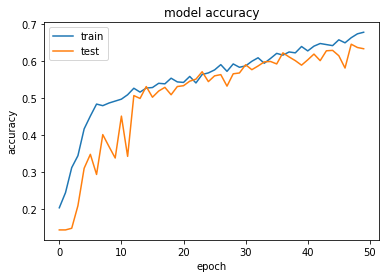

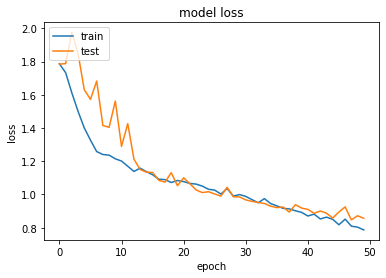

In [722]:
plt.plot(cnnhistory_lstm_mfcc.history['categorical_accuracy'])
plt.plot(cnnhistory_lstm_mfcc.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnnhistory_lstm_mfcc.history['loss'])
plt.plot(cnnhistory_lstm_mfcc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[ 80  32   5   0   5   8]
 [ 31  54  10   0  22  36]
 [ 20  12  51   0   9  52]
 [  0   0   0 158   0   0]
 [  2   0   4   0 154   5]
 [ 20  17  29   0  10  74]]


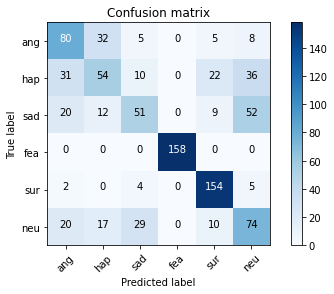

In [804]:
y_pred = model_mfcc_lstm.predict(X_testcnn_mfcc)
matrix = metrics.confusion_matrix(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [805]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.52      0.62      0.57       130
         hap       0.47      0.35      0.40       153
         sad       0.52      0.35      0.42       144
         fea       1.00      1.00      1.00       158
         sur       0.77      0.93      0.84       165
         neu       0.42      0.49      0.46       150

    accuracy                           0.63       900
   macro avg       0.62      0.62      0.61       900
weighted avg       0.62      0.63      0.62       900



### MEL

We use Mel Spectrogram as input features.

In [557]:
model_mel_lstm = Sequential()

#LFLB - Local Feature Learning Block

model_mel_lstm.add(Conv1D(32, 6,padding='same',input_shape=(128,1)))        #1
model_mel_lstm.add(Activation('relu'))
model_mel_lstm.add(MaxPooling1D(pool_size=(5)))
model_mel_lstm.add(BatchNormalization()) #
model_mel_lstm.add(Dropout(0.25))

model_mel_lstm.add(Conv1D(64, 6,padding='same',))                           #2
model_mel_lstm.add(Activation('relu'))
model_mel_lstm.add(MaxPooling1D(pool_size=(5)))
model_mel_lstm.add(Dropout(0.25))

model_mel_lstm.add(Conv1D(128, 6,padding='same',))                           #3
model_mel_lstm.add(Activation('relu'))
model_mel_lstm.add(Dropout(0.25))

model_mel_lstm.add(Conv1D(256, 6,padding='same',))                           #4 ...
model_mel_lstm.add(Activation('relu'))
model_mel_lstm.add(Dropout(0.25))

# LSTM
model_mel_lstm.add(LSTM(64,return_sequences=True))
model_mel_lstm.add(SeqSelfAttention(attention_activation='tanh'))
model_mel_lstm.add(LSTM(32,return_sequences=False))

# FC
model_mel_lstm.add(Dense(units=6, activation='softmax'))

In [558]:
model_mel_lstm.summary()

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_76 (Conv1D)           (None, 128, 32)           224       
_________________________________________________________________
activation_82 (Activation)   (None, 128, 32)           0         
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 25, 32)            0         
_________________________________________________________________
batch_normalization_187 (Bat (None, 25, 32)            128       
_________________________________________________________________
dropout_238 (Dropout)        (None, 25, 32)            0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 25, 64)            12352     
_________________________________________________________________
activation_83 (Activation)   (None, 25, 64)          

In [559]:
model_mel_lstm.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['categorical_accuracy', f1_loss])

In [560]:
cnnhistory_lstm_mel=model_mel_lstm.fit(X_traincnn_mel, y_onehot_train_mel, batch_size=50, epochs=60, validation_data=(X_testcnn_mel, y_onehot_test_mel), callbacks=[mcp_save, rlrop])

Epoch 1/60
42/42 [==============================] - 6s 58ms/step - loss: 1.7628 - categorical_accuracy: 0.2356 - f1_loss: 0.8262 - val_loss: 1.6891 - val_categorical_accuracy: 0.2511 - val_f1_loss: 0.7954
Epoch 2/60
42/42 [==============================] - 1s 34ms/step - loss: 1.5927 - categorical_accuracy: 0.3333 - f1_loss: 0.7779 - val_loss: 1.4349 - val_categorical_accuracy: 0.3411 - val_f1_loss: 0.7003
Epoch 3/60
42/42 [==============================] - 2s 38ms/step - loss: 1.4061 - categorical_accuracy: 0.4215 - f1_loss: 0.7005 - val_loss: 1.2799 - val_categorical_accuracy: 0.4467 - val_f1_loss: 0.6515
Epoch 4/60
42/42 [==============================] - 2s 39ms/step - loss: 1.3307 - categorical_accuracy: 0.4378 - f1_loss: 0.6660 - val_loss: 1.2738 - val_categorical_accuracy: 0.4356 - val_f1_loss: 0.6421
Epoch 5/60
42/42 [==============================] - 2s 43ms/step - loss: 1.2847 - categorical_accuracy: 0.4484 - f1_loss: 0.6527 - val_loss: 1.2815 - val_categorical_accuracy: 0.41

In [733]:
loss, acc, f1_score = model_mel_lstm.evaluate(X_testcnn_mel, y_onehot_test_mel)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 9ms/step - loss: 0.8370 - categorical_accuracy: 0.6444 - f1_loss: 0.4498
Restored model, accuracy: 64.44%


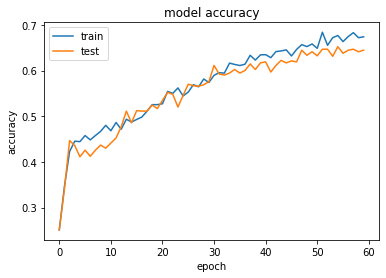

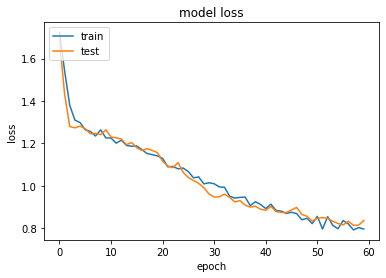

In [734]:
plt.plot(cnnhistory_lstm_mel.history['categorical_accuracy'])
plt.plot(cnnhistory_lstm_mel.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnnhistory_lstm_mel.history['loss'])
plt.plot(cnnhistory_lstm_mel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[103  13   5   0   0   9]
 [ 45  42  25   1  11  29]
 [ 19  24  42   1  10  48]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 16  23  35   0   6  70]]


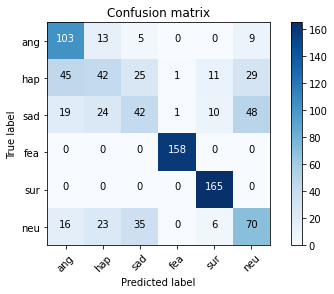

In [814]:
y_pred = model_mel_lstm.predict(X_testcnn_mel)
matrix = metrics.confusion_matrix(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [815]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.56      0.79      0.66       130
         hap       0.41      0.27      0.33       153
         sad       0.39      0.29      0.33       144
         fea       0.99      1.00      0.99       158
         sur       0.86      1.00      0.92       165
         neu       0.45      0.47      0.46       150

    accuracy                           0.64       900
   macro avg       0.61      0.64      0.62       900
weighted avg       0.62      0.64      0.62       900



## BASE CNN

#### MFCC

In [100]:
model_mfcc_base = Sequential()

model_mfcc_base.add(Conv1D(32, 6,padding='same',input_shape=(40,1)))        #1
model_mfcc_base.add(Activation('relu'))
model_mfcc_base.add(MaxPooling1D(pool_size=(5)))
model_mfcc_base.add(Dropout(0.01))

model_mfcc_base.add(Conv1D(128, 6,padding='same',))                           #2
model_mfcc_base.add(Activation('relu'))
#model_mfcc_base.add(MaxPooling1D(pool_size=(5)))
model_mfcc_base.add(Dropout(0.01))

model_mfcc_base.add(GlobalMaxPooling1D())
model_mfcc_base.add(Dense(6))                                                 #5
model_mfcc_base.add(Activation('softmax'))

In [101]:
model_mfcc_base.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 40, 32)            224       
_________________________________________________________________
activation_16 (Activation)   (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 8, 128)            24704     
_________________________________________________________________
activation_17 (Activation)   (None, 8, 128)            0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 8, 128)           

In [102]:
model_mfcc_base.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['categorical_accuracy', f1_loss])

In [103]:
cnnhistory_base_mfcc=model_mfcc_base.fit(X_traincnn_mfcc, y_onehot_train_mfcc, batch_size=50, epochs=100, validation_data=(X_testcnn_mfcc, y_onehot_test_mfcc), callbacks=[mcp_save, rlrop])

Epoch 1/100
42/42 [==============================] - 2s 32ms/step - loss: 12.4479 - categorical_accuracy: 0.1880 - f1_loss: 0.9204 - val_loss: 3.1912 - val_categorical_accuracy: 0.3044 - val_f1_loss: 0.8508
Epoch 2/100
42/42 [==============================] - 1s 13ms/step - loss: 2.6161 - categorical_accuracy: 0.2381 - f1_loss: 0.8146 - val_loss: 1.8022 - val_categorical_accuracy: 0.3722 - val_f1_loss: 0.7616
Epoch 3/100
42/42 [==============================] - 1s 13ms/step - loss: 1.9311 - categorical_accuracy: 0.3032 - f1_loss: 0.7644 - val_loss: 1.5393 - val_categorical_accuracy: 0.3356 - val_f1_loss: 0.7426
Epoch 4/100
42/42 [==============================] - 1s 15ms/step - loss: 1.6522 - categorical_accuracy: 0.3920 - f1_loss: 0.7271 - val_loss: 1.6768 - val_categorical_accuracy: 0.3833 - val_f1_loss: 0.7340
Epoch 5/100
42/42 [==============================] - 1s 15ms/step - loss: 1.6986 - categorical_accuracy: 0.3494 - f1_loss: 0.7292 - val_loss: 1.4193 - val_categorical_accuracy

In [745]:
loss, acc, f1_score = model_mfcc_base.evaluate(X_testcnn_mfcc, y_onehot_test_mfcc)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 4ms/step - loss: 0.8917 - categorical_accuracy: 0.6478 - f1_loss: 0.4865
Restored model, accuracy: 64.78%


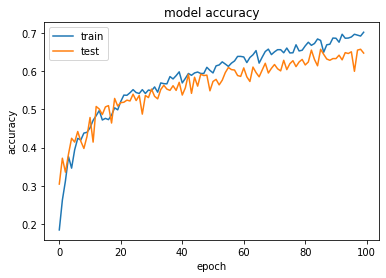

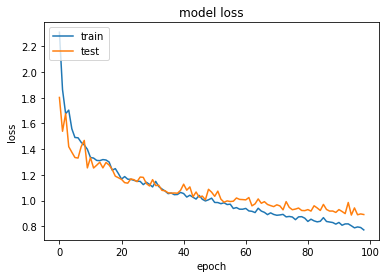

In [746]:
plt.plot(cnnhistory_base_mfcc.history['categorical_accuracy'])
plt.plot(cnnhistory_base_mfcc.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnnhistory_base_mfcc.history['loss'][1:])
plt.plot(cnnhistory_base_mfcc.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[ 94   5   7   1  14   9]
 [ 35  39  28   1  24  26]
 [ 16   9  73   0   6  40]
 [  0   0   0 158   0   0]
 [  0   0  12   0 147   6]
 [ 14  10  42   1  11  72]]


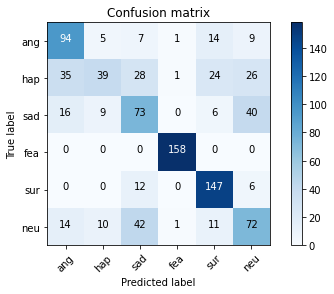

In [824]:
y_pred = model_mfcc_base.predict(X_testcnn_mfcc)
matrix = metrics.confusion_matrix(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [825]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.59      0.72      0.65       130
         hap       0.62      0.25      0.36       153
         sad       0.45      0.51      0.48       144
         fea       0.98      1.00      0.99       158
         sur       0.73      0.89      0.80       165
         neu       0.47      0.48      0.48       150

    accuracy                           0.65       900
   macro avg       0.64      0.64      0.63       900
weighted avg       0.65      0.65      0.63       900



#### Mel

In [653]:
model_mel_base = Sequential()

model_mel_base.add(Conv1D(32, 6,padding='same',input_shape=(128,1)))        #1
model_mel_base.add(Activation('relu'))
#model_mel_base.add(MaxPooling1D(pool_size=(5)))
model_mel_base.add(BatchNormalization())
model_mel_base.add(Dropout(0.01))

model_mel_base.add(Conv1D(64, 6,padding='same',))                           #2
model_mel_base.add(Activation('relu'))
#model_mel_base.add(BatchNormalization())
model_mel_base.add(Dropout(0.01))

model_mel_base.add(GlobalMaxPooling1D())
model_mel_base.add(Dense(6))                                                 #5
model_mel_base.add(Activation('softmax'))

In [654]:
model_mel_base.summary()
model_mel_base.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['categorical_accuracy', f1_loss])

Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_88 (Conv1D)           (None, 128, 32)           224       
_________________________________________________________________
activation_98 (Activation)   (None, 128, 32)           0         
_________________________________________________________________
batch_normalization_232 (Bat (None, 128, 32)           128       
_________________________________________________________________
dropout_286 (Dropout)        (None, 128, 32)           0         
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 128, 64)           12352     
_________________________________________________________________
activation_99 (Activation)   (None, 128, 64)           0         
_________________________________________________________________
dropout_287 (Dropout)        (None, 128, 64)        

In [655]:
cnnhistory_base_mel=model_mel_base.fit(X_traincnn_mel, y_onehot_train_mel, batch_size=50, epochs=60, validation_data=(X_testcnn_mel, y_onehot_test_mel), callbacks=[mcp_save, rlrop])

Epoch 1/60
42/42 [==============================] - 2s 36ms/step - loss: 3.1906 - categorical_accuracy: 0.2094 - f1_loss: 0.8276 - val_loss: 2.2010 - val_categorical_accuracy: 0.2589 - val_f1_loss: 0.7719
Epoch 2/60
42/42 [==============================] - 1s 17ms/step - loss: 1.7187 - categorical_accuracy: 0.3109 - f1_loss: 0.7671 - val_loss: 1.6477 - val_categorical_accuracy: 0.3589 - val_f1_loss: 0.7390
Epoch 3/60
42/42 [==============================] - 1s 16ms/step - loss: 1.5520 - categorical_accuracy: 0.3836 - f1_loss: 0.7351 - val_loss: 1.5525 - val_categorical_accuracy: 0.4233 - val_f1_loss: 0.7152
Epoch 4/60
42/42 [==============================] - 1s 16ms/step - loss: 1.4233 - categorical_accuracy: 0.4312 - f1_loss: 0.7060 - val_loss: 1.4761 - val_categorical_accuracy: 0.4111 - val_f1_loss: 0.7133
Epoch 5/60
42/42 [==============================] - 1s 17ms/step - loss: 1.4163 - categorical_accuracy: 0.4491 - f1_loss: 0.7013 - val_loss: 1.4974 - val_categorical_accuracy: 0.40

In [757]:
loss, acc, f1_score = model_mel_base.evaluate(X_testcnn_mel, y_onehot_test_mel)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 5ms/step - loss: 1.1010 - categorical_accuracy: 0.5822 - f1_loss: 0.5439
Restored model, accuracy: 58.22%


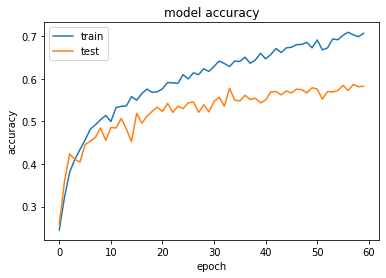

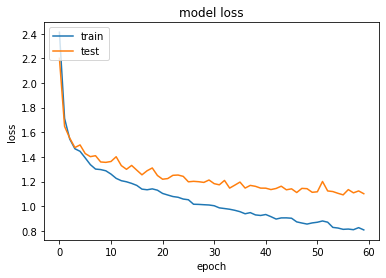

In [758]:
plt.plot(cnnhistory_base_mel.history['categorical_accuracy'])
plt.plot(cnnhistory_base_mel.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnnhistory_base_mel.history['loss'])
plt.plot(cnnhistory_base_mel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[ 75  26  10   1  11   7]
 [ 30  55  24   3  13  28]
 [ 23  37  33   4  11  36]
 [  0   0   0 158   0   0]
 [  1   6   1   4 153   0]
 [ 23  29  32   5  11  50]]


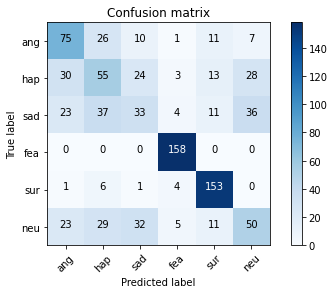

In [834]:
y_pred = model_mel_base.predict(X_testcnn_mel)
matrix = metrics.confusion_matrix(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [835]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.49      0.58      0.53       130
         hap       0.36      0.36      0.36       153
         sad       0.33      0.23      0.27       144
         fea       0.90      1.00      0.95       158
         sur       0.77      0.93      0.84       165
         neu       0.41      0.33      0.37       150

    accuracy                           0.58       900
   macro avg       0.54      0.57      0.55       900
weighted avg       0.55      0.58      0.56       900

